# *WORKING file:* Species abundance model
### Description:
Create a tutorial for a marine species abundance model in python. This notebook was created at the PACE Hackweek 2025. Our use-case will be with [NOAA NEFSC bottom trawl](https://www.fisheries.noaa.gov/new-england-mid-atlantic/science-data/2025-spring-bottom-trawl-survey-completed-northeast) data, specifically longfin squid.


![longfin squid!](https://img.freepik.com/free-vector/hand-drawn-squid-illustration_23-2149560574.jpg?semt=ais_hybrid&w=740&q=80)
### Authors: 
* Haley Synan (NOAA Fisheries/IBSS)
* Artem Dzhulai (URI)
* Sajna Hussain
* Natalie McCourt (UMBC)
### History:
>*8/4/25: notebook initialized*


### Run command to get push access to our SDM repo
gh-scoped-creds

# STEPS
* [x] Get fisheries data
* [x] Preliminary analysis of ALL species abundance
* [x] Match the PACE data
* [x] Match GLORYS data 
* [ ] Choose explanatory variables
    * PAR
    * KD490
    * MOANA
    * phyto_carbon
* [ ] Match data
* [ ] Run model (xgboost) 

In [1]:
!pip install copernicusmarine

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import xarray as xr
import earthaccess
from match_func import match_nearest
import netCDF4
import h5netcdf
import copernicusmarine
import geopandas as gpd
import earthaccess
import xarray as xr
auth = earthaccess.login(persist=True)

In [3]:
os.chdir(r'/home/jovyan/Hackweek2025/proj_2025_sdm/data')
trawl_df = pd.read_csv('fisheries_with_pace_rrs_avw2.csv') #read data 
# --- Data Cleaning (Crucial Step!) ---

# 1. Ensure the date column is a proper datetime object.
#    This is vital for matching with the environmental data.
trawl_df['TOWDATETIME_EST'] = pd.to_datetime(trawl_df['TOWDATETIME_EST'])

# 2. Ensure coordinates are numeric
trawl_df['LON'] = pd.to_numeric(trawl_df['LON'])
trawl_df['LAT'] = pd.to_numeric(trawl_df['LAT'])

# Display the first few rows and data types to verify
print("Catch Data Head:")
print(trawl_df.head())
print("\nData Types:")
print(trawl_df.info())

# --- Standardize Column Names to Match Xarray Dims ---
# This is the crucial step to ensure congruency.
rename_dict = {
    'TOWDATETIME_EST': 'time',
    'LAT': 'latitude',
    'LON': 'longitude'
}
trawl_df = trawl_df.rename(columns=rename_dict)

Catch Data Head:
      TOWDATETIME_EST        LAT        LON  MEAN_DEPTH  SWEPT_AREA_km  \
0 2024-03-07 10:58:00  38.659194 -74.828083          24       0.021282   
1 2024-03-07 14:32:00  38.498596 -74.477395          40       0.024311   
2 2024-03-07 17:44:00  38.411974 -74.502885          39       0.023835   
3 2024-03-07 20:29:00  38.505238 -74.832046          25       0.021510   
4 2024-03-07 22:45:00  38.556784 -74.897495          21       0.019174   

   acadian redfish  alewife  alligatorfish  american lobster  american plaice  \
0              0.0      0.0            0.0               0.0              0.0   
1              0.0      0.0            0.0               0.0              0.0   
2              0.0      0.0            0.0               0.0              0.0   
3              0.0      0.0            0.0               1.0              0.0   
4              0.0      0.0            0.0              27.0              0.0   

   ...   Rrs_707   Rrs_708   Rrs_709   Rrs_711   Rr

## Data exploration
We want to find a species (or few) that would be the most useful to model. We will sort the species by total number of observations over the entire survey. We will plot that as a faux time series, using station number instead of datetime. Then we will find species that have more than 50,000 observations over the survey period. This is a crude way to remove the species that were rarely seen and wouldn't be a good fit to model. 

/tmp/ipykernel_13300/79794507.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['station'] = np.arange(1,len(sub)+1) #add station col


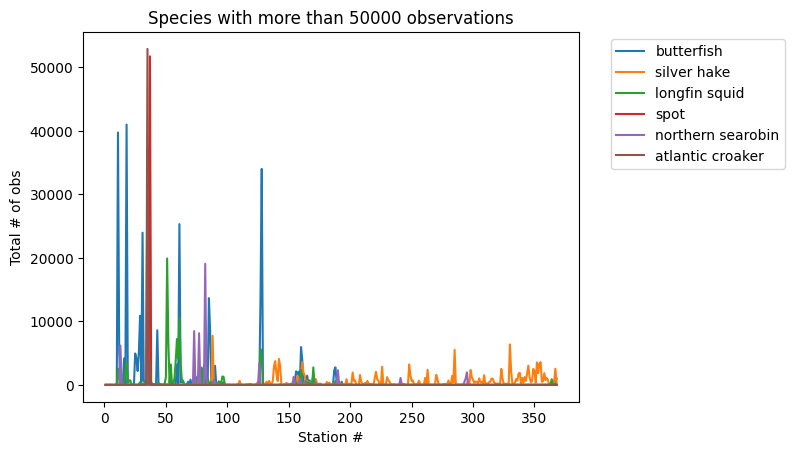

In [4]:
matched=[]
for item in trawl_df.columns:
    if 'Rrs' in item:  # Using the 'in' operator for substring check
        pass
    else: 
        matched.append(item)

sub = trawl_df[list(matched)] #subset (remove RRS columns) 
sub['station'] = np.arange(1,len(sub)+1) #add station col

tot_sum = {}
for s in sub.columns[5:-2]:
   tot_sum.update({s:int(sub[s].sum())})  #get total sum of all values 

sorted_tot_sum = sorted(tot_sum.items(), key=lambda item: item[1],reverse=True) #sort by max-->min


abu=[]
for val in sorted_tot_sum:
    if val[1]>50000: #if more than 50000 observations 
        abu.append(val[0])


#plot max valeus 
for s in sub[abu].columns:
    plt.plot(sub.station, sub[s],label=s)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )
plt.xlabel('Station #')
plt.ylabel('Total # of obs')
plt.title('Species with more than 50000 observations')
plt.show()

Now we have the 6 most dominant (in total # of obs) over the survey period. We 

Text(0.5, 0.98, 'Species presence by station')

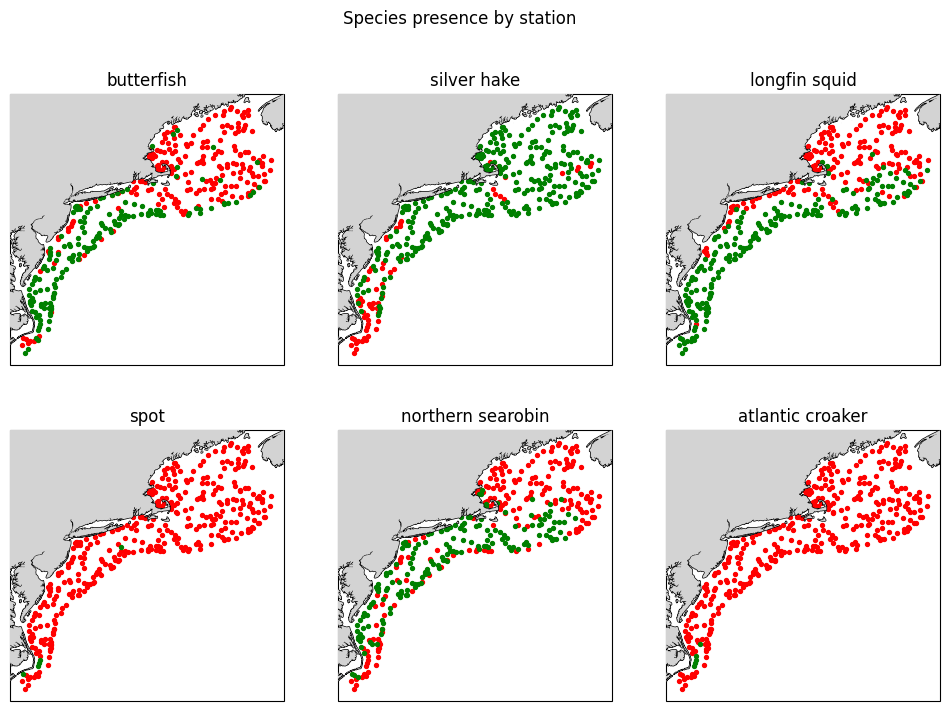

In [5]:
# Create a figure and a 3x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8),subplot_kw={'projection': cartopy.crs.PlateCarree()}) 

# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten() 

# Example data for plotting
x = np.linspace(0, 10, 100)

# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    ax.scatter(sub[sub[sub[abu].columns[i]]==0].longitude, sub[sub[sub[abu].columns[i]]==0].latitude,c='r',s=8,label='no')
    ax.scatter(sub[sub[sub[abu].columns[i]]!=0].longitude, sub[sub[sub[abu].columns[i]]!=0].latitude,c='g',s=8)
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey') #add land mask 
    ax.set_title(sub[abu].columns[i])
fig.suptitle('Species presence by station')

## Add PACE data
We will be using chlorophyll, avw, and RRS brightness

In [6]:
def get_pace_path(trawl_df, short_name):
    tspan = (trawl_df.date.min(), trawl_df.date.max())
    bbox = (-76.75, 33, -63, 46) #west,south,east,north
    #clouds = (0, 50)
    results = earthaccess.search_data(
        short_name=short_name,
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.8*.4km*")
        #cloud_cover=clouds,
    paths = earthaccess.open(results)
    return paths 


def open_pace(paths): 
    d8=[]
    for file in paths: 
        d = xr.open_dataset(file)
        d8.append(d.attrs['time_coverage_start'])
    ds = xr.open_mfdataset(paths, combine='nested',concat_dim='datetime').assign_coords({'time':d8}) #add new dimension and assign time data to it
    ds = ds.rename({'datetime':'time'}) #rename to time
    ds = ds.where((ds.lat > 34.40918) & (ds.lat < 46.362305) & (-63>ds.lon) & (-77< ds.lon),drop=True) #general spatial subset
    ds = ds.rename({'lat':'latitude','lon':'longitude'})
    #ds['time']=[pd.to_datetime(d) for d in ds.time.values] #convert to pandas datetime 
    ds['time'] = pd.to_datetime(ds.time) #convert to pandas datetime 
    return ds

#trawl_df pre-processing
trawl_df['date'] = [str(d).split(' ')[0] for d in trawl_df.time] 
#trawl_df['time'] = [pd.to_datetime(d.replace(' ','T')) for d in trawl_df.TOWDATETIME_EST] #format as timestamp

#get pace data 
paths_avw= get_pace_path(trawl_df,"PACE_OCI_L3M_AVW")
paths_chl= get_pace_path(trawl_df,"PACE_OCI_L3M_CHL")
paths_kd= get_pace_path(trawl_df,"PACE_OCI_L3M_KD")


ds_avw, ds_chl = list(map(open_pace,[paths_avw, paths_chl])) #get path values for each variable 

#match data 
data=[ds_avw, ds_chl] #list of datasets
var_names =['avw','chlor_a'] #list of variable names 
for d in range(len(data)): 
    if d == 0: 
        trawl_df = match_nearest(trawl_df,data[d],var_names[d],var_names[d],date=trawl_df.time) #get full trawl_df + avw 
    else: 
        trawl_df[var_names[d]]=match_nearest(trawl_df,data[d],var_names[d],var_names[d],date=trawl_df.time)[var_names[d]] #add chl in 
    
trawl_df

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

,avw,time,latitude,longitude,MEAN_DEPTH,SWEPT_AREA_km,acadian redfish,alewife,alligatorfish,american lobster,...,Rrs_709,Rrs_711,Rrs_712,Rrs_713,Rrs_714,Rrs_717,Rrs_719,Rrs_brightness,date,chlor_a
0,506.8169,2024-03-07 10:58:00,38.659194,-74.828083,24,0.021282,0.0,0.0,0.0,0.0,...,0.000797,0.000765,0.000738,0.000717,0.000689,0.000552,0.000540,1.090205,2024-03-07,2.0587218
1,nan,2024-03-07 14:32:00,38.498596,-74.477395,40,0.024311,0.0,0.0,0.0,0.0,...,0.000364,0.000344,0.000333,0.000325,0.000315,0.000229,0.000261,0.907649,2024-03-07,nan
2,nan,2024-03-07 17:44:00,38.411974,-74.502885,39,0.023835,0.0,0.0,0.0,0.0,...,0.000350,0.000330,0.000318,0.000310,0.000292,0.000210,0.000254,0.935354,2024-03-07,nan
3,nan,2024-03-07 20:29:00,38.505238,-74.832046,25,0.021510,0.0,0.0,0.0,1.0,...,0.000632,0.000606,0.000588,0.000574,0.000553,0.000430,0.000434,1.050127,2024-03-07,nan
4,nan,2024-03-07 22:45:00,38.556784,-74.897495,21,0.019174,0.0,0.0,0.0,27.0,...,0.001221,0.001175,0.001134,0.001093,0.001046,0.000848,0.000791,1.327782,2024-03-07,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,511.90198,2024-05-12 12:30:00,41.305711,-70.636614,23,0.018435,0.0,0.0,0.0,0.0,...,0.000266,0.000253,0.000246,0.000243,0.000237,0.000181,0.000218,0.529729,2024-05-12,1.9841743
364,493.188,2024-05-12 18:45:00,40.467061,-71.381195,73,0.022568,0.0,2.0,0.0,2.0,...,0.000150,0.000142,0.000140,0.000137,0.000138,0.000097,0.000150,0.446814,2024-05-12,0.8285737
365,486.04074,2024-05-13 01:19:00,39.618178,-72.027289,219,0.024705,0.0,0.0,0.0,0.0,...,0.000102,0.000094,0.000093,0.000094,0.000095,0.000057,0.000104,0.450264,2024-05-13,0.45518643
366,491.53732,2024-05-13 03:42:00,39.762143,-72.213598,98,0.020737,0.0,1.0,0.0,0.0,...,0.000141,0.000134,0.000134,0.000133,0.000130,0.000068,0.000124,0.446797,2024-05-13,0.7093886


## Add GLORYS data

In [40]:
glorys_ds= copernicusmarine.open_dataset(dataset_id = 'cmems_mod_glo_phy_myint_0.083deg_P1D-m',minimum_longitude=-77, maximum_longitude=-63,minimum_latitude=34,maximum_latitude=46,)
glorys_subset = glorys_ds.where(glorys_ds['time.year'] > 2023, drop=True) #spatial subset

INFO - 2025-08-05T19:34:59Z - Selected dataset version: "202311"
INFO - 2025-08-05T19:34:59Z - Selected dataset part: "default"
INFO - 2025-08-05T19:34:59Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username:

  hsynan1


Copernicus Marine password:

  ········


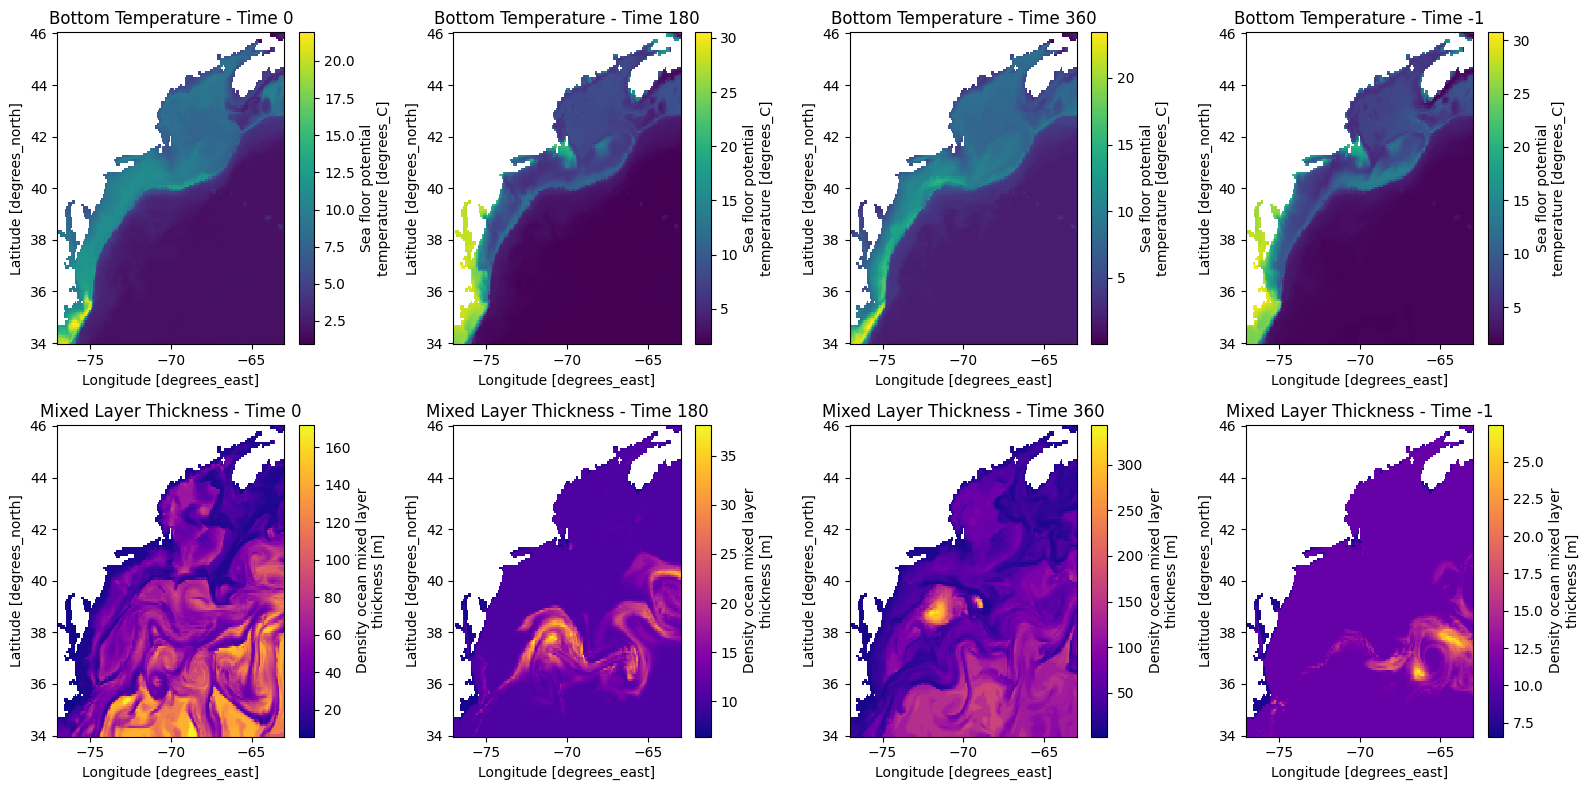

In [41]:
# Select four time slices (modify indices if needed)
time_indices = [0, int(len(glorys_subset.time)/3), int(2*len(glorys_subset.time)/3), -1]

# Set up figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for i, t in enumerate(time_indices):
    # Plot 
    ax = axes[0, i]
    glorys_subset.bottomT.isel(time=t).plot(ax=ax, cmap="viridis")
    ax.set_title(f"Bottom Temperature - Time {t}")

    # Plot 2
    ax = axes[1, i]
    glorys_subset.mlotst.isel(time=t).plot(ax=ax, cmap="plasma")
    ax.set_title(f"Mixed Layer Thickness - Time {t}")

# Adjust layout
plt.tight_layout()
plt.show()


In [7]:
glorys_ds['time'] = [pd.Timestamp(d) for d in glorys_ds.time.values]

In [14]:
match_nearest(trawl_df,glorys_ds,'bottomT','temp',date=trawl_df.time)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fb1f70f5190>>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [13]:
glorys_ds

<xarray.Dataset> Size: 422GB
Dimensions:    (depth: 50, latitude: 145, longitude: 169, time: 10408)
Coordinates:
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 580B 34.0 34.08 34.17 ... 45.83 45.92 46.0
  * longitude  (longitude) float32 676B -77.0 -76.92 -76.83 ... -63.08 -63.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    bottomT    (time, latitude, longitude) float64 2GB dask.array<chunksize=(2081, 16, 32), meta=np.ndarray>
    mlotst     (time, latitude, longitude) float64 2GB dask.array<chunksize=(2081, 16, 32), meta=np.ndarray>
    siconc     (time, latitude, longitude) float64 2GB dask.array<chunksize=(2081, 16, 32), meta=np.ndarray>
    sithick    (time, latitude, longitude) float64 2GB dask.array<chunksize=(2081, 16, 32), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float64 102GB dask.array<chunksize=(2081, 50, 16, 32), meta=np.ndarray>
    thetao     (time, depth, latitude, longitude) float64 102GB dask.array<chunksize=(2081, 50, 16, 32), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float64 102GB dask.array<chunksize=(2081, 50, 16, 32), meta=np.ndarray>
    usi        (time, latitude, longitude) float64 2GB dask.array<chunksize=(2081, 16, 32), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float64 102GB dask.array<chunksize=(2081, 50, 16, 32), meta=np.ndarray>
    vsi        (time, latitude, longitude) float64 2GB dask.array<chunksize=(2081, 16, 32), meta=np.ndarray>
    zos        (time, latitude, longitude) float64 2GB dask.array<chunksize=(2081, 16, 32), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    history:      2023/06/01 16:20:05 MERCATOR OCEAN Netcdf creation
    source:       MERCATOR GLORYS12V1
    institution:  MERCATOR OCEAN
    references:   http://www.mercator-ocean.fr
    comment:      CMEMS product
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...

In [51]:
ds_avw.time.values

array(['2024-03-05T00:08:58.000Z', '2024-03-15T20:10:13.000Z',
       '2024-03-20T23:40:37.000Z', '2024-03-29T00:54:40.000Z',
       '2024-04-06T00:35:00.000Z', '2024-04-14T00:25:17.000Z',
       '2024-04-22T00:10:19.000Z', '2024-04-29T23:54:57.000Z',
       '2024-05-07T23:44:24.000Z'], dtype='<U24')

In [69]:
glorys_ds['bottomT'].sel(time=df.date[i],
                                           latitude=df.LAT[i],
                                           longitude=df.LON[i],
                                           method='nearest'
                                           )

<xarray.DataArray 'bottomT' ()> Size: 8B
dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    latitude   float32 4B 38.5
    longitude  float32 4B -74.83
    time       datetime64[ns] 8B 2021-06-30
Attributes:
    cell_methods:   area: mean
    long_name:      Sea floor potential temperature
    standard_name:  sea_water_potential_temperature_at_sea_floor
    unit_long:      Degrees Celsius
    units:          degrees_C
    valid_max:      21299
    valid_min:      -32756